### Instalando o Valgrind

In [171]:
!apt-get install valgrind

Reading package lists... Done
Building dependency tree       
Reading state information... Done
valgrind is already the newest version (1:3.13.0-2ubuntu2.3).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


### Instalando o C++

In [172]:
!git config --global url."https://".insteadOf git://
!pip install git+git://github.com/canesche/nvcc4jupyter.git
!git clone https://github.com/canesche/nvcc4jupyter
%load_ext nvcc_plugin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning git://github.com/canesche/nvcc4jupyter.git to /tmp/pip-req-build-ivedzu05
  Running command git clone -q git://github.com/canesche/nvcc4jupyter.git /tmp/pip-req-build-ivedzu05
fatal: destination path 'nvcc4jupyter' already exists and is not an empty directory.
The nvcc_plugin extension is already loaded. To reload it, use:
  %reload_ext nvcc_plugin


Criando o arquivo da heurística

In [173]:
%%writefile heuristica.cpp
#include <iostream>
#include <vector>
#include <algorithm>

using namespace std;
struct dna
{
    int id;
    char dna_value;
};

struct dna_matrix
{
    int id;
    int value;
    int x_last;
    int y_last;
    int x_current;
    int y_current;
    char x_value;
    char y_value;
};

int main() {

    // Defining n and m. Value of n is the length of the first sequence. Value of m is the length of the second sequence.
    int n; int m;

    // Reads n and m. 
    cin >> n >> m;

    // Defining the two vectors that receive the sequences.
    vector<dna> dnas_first_seq;
    vector<dna> dnas_second_seq;

    // Reserving n and m length on the vectors.
    dnas_first_seq.reserve(n);
    dnas_second_seq.reserve(m);

    dna dna_next;

    // Reads the first sequence and completes the dna_first_seq vector with the sequence.
    for(int i = 0; i < n; i++) {
        cin >> dna_next.dna_value;
        dna_next.id = i;
        dnas_first_seq.push_back(dna_next);
    }

    // Reads the second sequence and completes the dna_second_seq vector with the sequence.
    for(int i = 0; i < m; i++) {
        cin >> dna_next.dna_value;
        dna_next.id = i;
        dnas_second_seq.push_back(dna_next);
    }

    // Creating the matrix that will be used to Smith-Waterman algorithm.
    vector<vector<dna_matrix> > matrix;

    vector<dna_matrix> line;

    dna_matrix line_matrix;

    // Creating the first line of zeros of the matrix.
    for (int i = 0; i <= n; i++) {
        line_matrix.id = i;
        line_matrix.value = 0;
        line_matrix.x_last = 0;
        line_matrix.y_last = 0;
        line.push_back(line_matrix);
    }
    matrix.push_back(line);

    // Creating the first column with zeros of the matrix.
    for (int i = 1; i <= n; i++) {
        vector<dna_matrix> line_loop;
        for (int j = 0; j <= m; j++) {
            if (j == 0){
                line_loop.push_back(line_matrix);
            } else {
                line_loop.push_back(line_matrix);
            }
        }
        matrix.push_back(line_loop);
    }

    // Loop over the matrix
    for (int i = 1; i <= n; i++) {
        for (int j = 1; j <= m; j++) {
            int diagonal = 0;

            matrix[i][j].x_value = dnas_first_seq[i-1].dna_value;
            matrix[i][j].y_value = dnas_second_seq[j-1].dna_value;

            // Calculate the diagonal. Seeing if its a mismatch, a gap or a match.
            if (dnas_first_seq[i-1].dna_value == dnas_second_seq[j-1].dna_value) {
                diagonal = matrix[i-1][j-1].value + 2;
            } else {
                diagonal = matrix[i-1][j-1].value - 1;
            }

            // Calculate the delection.
            int delection = matrix[i-1][j].value - 1;
            // Calculate the insertion.
            int insertion = matrix[i][j-1].value - 1;
            // Get the maximum between diagonal, delection, insertion and 0.
            int max_between_diagonal_delection = max(diagonal,delection);
            int max_between_diagonal_delection_insertion = max(max_between_diagonal_delection, insertion);
            int max_between_diagonal_delection_insertion_zero = max(max_between_diagonal_delection_insertion, 0);
            matrix[i][j].value = max_between_diagonal_delection_insertion_zero;

            if (max_between_diagonal_delection_insertion_zero == diagonal) {
                matrix[i][j].x_last = i - 1;
                matrix[i][j].y_last = j - 1;
                matrix[i][j].x_current = i;
                matrix[i][j].y_current = j;
            } else if (max_between_diagonal_delection_insertion_zero == delection) {
                matrix[i][j].x_last = i - 1;
                matrix[i][j].y_last = j;
                matrix[i][j].x_current = i;
                matrix[i][j].y_current = j;
            } else if (max_between_diagonal_delection_insertion_zero == insertion) {
                matrix[i][j].x_last = i;
                matrix[i][j].y_last = j - 1;
                matrix[i][j].x_current = i;
                matrix[i][j].y_current = j;
            } else {
                matrix[i][j].x_last = i - 1;
                matrix[i][j].y_last = j - 1;
                matrix[i][j].x_current = i;
                matrix[i][j].y_current = j;
            }
        }
    }

    // for(auto& el: matrix) {
    //    for(auto& element: el) {
    //        cout << element.value;
    //    }
    //    cout << endl;
    // }

    // Get the max element of the matrix.
    dna_matrix max_element;
    for (int i = 0; i <= n; i++) {
        for (int j = 0; j <= m; j++) {
            if (matrix[i][j].value > max_element.value) {
                max_element = matrix[i][j];
            }
        }
    }

    int i = max_element.x_current;
    int j = max_element.y_current;
    int value_max_element = max_element.value;

    vector<char> first_seq_answer;
    vector<char> second_seq_answer;

    // Get the best sequence.
    while (matrix[i][j].x_current != 0 || matrix[i][j].y_current != 0) {

        first_seq_answer.push_back(matrix[i][j].x_value);
        second_seq_answer.push_back(matrix[i][j].y_value);

        i = matrix[i][j].x_last;
        j = matrix[i][j].y_last;

        if (matrix[i][j].x_current == 0 || matrix[i][j].y_current == 0) {
            first_seq_answer.push_back(matrix[i][j].x_value);
            second_seq_answer.push_back(matrix[i][j].y_value);
            break;
        }
    }

    for (auto& el: first_seq_answer) {
        cout << el;
    }

    cout << endl;

    for (auto& el: second_seq_answer) {
        cout << el;
    }

    return 0;
}



Overwriting heuristica.cpp


In [174]:
!g++ -g heuristica.cpp -o heuristic

### Criando o primeiro arquivo de entrada contendo duas sequências de 1000 elementos

In [175]:
%%writefile in4.txt
1000
1000
AT-TT-GGGGC--CCGC-GATCCC-AC-G-CAG-GC-CGCCT-C-AGTT-GTTT-TCCGAAATGT--T-G-A-TTGGCA-ATCTGTT--A-C-CGGGCATCT-GGGC-C-ATCTACT-G-GTCTTA-ATTAGGTTGTTA-AT-CA-GGCCAGAAGGAAA--TGTATA-GTTTCAG-CA--GAT--CTTCAACACAGTA--TA-AGCAAG-CGGC-TC-GCTGCTGAGTGATTGT-CGAAC--ATGAGTT--GGTGC-ATTT-ATGTT--CTAATATCT-GCAGCGAAGACTAGGTAC-GTGG-C-ACCGTCCAGAGGAAAT-GGCTTAGCTCTAG-GCCTCTCGTTTT-GA-ATGG-G-C-GGTGC-C-CGG-A-CCTAC-C-GT--GGCGC-CCCT-TAAGGACA--CTC-GCCCACGG--AGAGA-TAT-GACA-G-TTGGACCACAT-C-CA-GTT-C-AGG-CCGTGAA---CAGTGATC-TACTAT-TT-C-CGT--GGTG--GTAGTAGAG-T--CTTCC-AAGA-TAGAACTACAC-GTAT-TAG-CGG-T--TAAA-CTTAGTAGCTGA-CATT-GGA-AAT-GCTTCCGCGCCAG-CTACACGCA-TGAAGT-CTTAGAG-TG-GGTGTTCACGGATC-GAAGCGTCGG-GGACGTACGGTTTGGA--GT-CG--CT--TG-A-AAACCTCT-T-CT-GAT-AGCTAGGTG-ACACGTCTTTGGTG-TCAATAAA-A-AGTTGGGC-AGGT-TATTA-CTAC-TAAGAC--CGA-CT-GCTGG-TT-GGTGCCT-AA--CGGCTGATA-CCTGTT-TA-GAGCCT-TTTGCAT-C-TATAC-ACG-TACA-AA--GTTTAA---T-GAGTC---CGT-GC-GACGCTTT--G-TCAC-CGCG--AGTGTAG-G-GCGC-AAAT-AG-GTG-CGC-T-TTAGC-CCACGTG--TGT-GAC--TA-A-TAAA-C-GTCACC-TGAA-TG-GTG
G-AG-TTT-GTGTGC-AGAAATGCTCGTCATCT-TTGA-CA-CTAGTTATGC-AGGTTC-C-CCACCGCG-GA-ACTATCGTGCTGCATAGCACCAA-GGGAGTTGACTGG-GG--CTCATAC-G--ACTG--GCCAGCTT-AGCGGTACCGATCGGAT---TGCGCTGTA-ACCCATG-CCA-GACATCCTGCT-T-CGTCCCAGCGCGTCTAGTGTTTAC-GA--ACATG-G--GAT-G-CATGGTA-CGTAGTC-C-CCACAATT--T-TCTCTCCGGCGAGC-TAA--GGAA--T-T-CG-ACGAGC-T-TGAAA--C-TGGCTA-----T--CAT-CCGC--ACCTGGCACT---GGAGTGACTGAACG-GAGTGCCGTGAAGC---CGGAGG-AAAAT-AGCT-TGCCAGCCACC-CG--C-ACGGTCG-GTT-CAC-ACG--GCAAAG--TA-GGAACGGGTCCG-CCA-AACCGGAGATT-TGT-TA-T-T-TGCTCCACG-G--C-GTGA-GGGGCAA-T-GTACTCTT--GAGCATTGCT-CTTACTTACGTTG-TA-G-ACGTAGTGAGTGCGAC-GGAGTC--GACCCGCCTTGCCG-AAAACGTGTATTCGACT-C-TTGG-GC-GTTATATCT--AT-TCGTTG-TCCATGTAA----TA-GATTT-TA-TAGGTATC-CG-TAAA-TCACGGC-ATTAT-GTCTCCAC-ACTATTACT-AA-CGGTTGATA-G-CTTATG---AATAAGGG-TTTCTATT-AGATCCGTCGGGA-GAGG-A---GTATATGA-G--GGAC-GG-AAC--AGGGCATGCGCT--AT-TTACTGCG--TCCCA-GAT-A-CGGG-GGTTAACT-TTTCCG-ACC-ACGCTGGCTG-A-CAG-ACG--GTC---A-GCA-TTAG-G-GCACA-CTCTGGATGGCA-AGTTTC-ATTTG-AGA-TTAT-TGATC-A-ATGGA-C--GAC-TG-GTTCAG

Overwriting in4.txt


### Executando o valgrind e o callgrind annotate para a heurística

In [176]:
!valgrind --tool=callgrind ./heuristic < in4.txt

==3143== Callgrind, a call-graph generating cache profiler
==3143== Copyright (C) 2002-2017, and GNU GPL'd, by Josef Weidendorfer et al.
==3143== Using Valgrind-3.13.0 and LibVEX; rerun with -h for copyright info
==3143== Command: ./heuristic
==3143== 
==3143== For interactive control, run 'callgrind_control -h'.
==3143== brk segment overflow in thread #1: can't grow to 0x4a2c000
==3143== (see section Limitations in user manual)
==3143== NOTE: further instances of this message will not be shown
==3143== 
==3143== Process terminating with default action of signal 2 (SIGINT)
==3143==    at 0x1098EF: main (heuristica.cpp:160)
==3143== 
==3143== Events    : Ir
==3143== Collected : 2699946367
==3143== 
==3143== I   refs:      2,699,946,367
^C


In [177]:
!callgrind_annotate callgrind.out.616 heuristica.cpp 

File callgrind.out.616 not opened


De acordo com o resultado do profilling do projeto 1, da heuristíca, é possível verificar que existe uma grande quantidade de acessos a memória, na casa dos bilhões. Além disso é possível observar que o ponto que teve mais lentidão foi a montagem da resposta fazendo o *trace* de toda a cadeia do sequenciamento genético. Mas mesmo assim podemos observar que o código é eficiente mesmo para entradas grandes com os seguintes tempos:

In [178]:
from tabulate import tabulate

In [179]:
table = [['Tamanho das sequências', 'Tempo'], ['200x200', '0.0043'], ['400x200', '0.0117'], ['400x400', '0.0159'], ['1000x1000', '0.0284']]

In [180]:
print(tabulate(table, headers='firstrow', tablefmt='grid'))

+--------------------------+---------+
| Tamanho das sequências   |   Tempo |
+==========================+=========+
| 200x200                  |  0.0043 |
+--------------------------+---------+
| 400x200                  |  0.0117 |
+--------------------------+---------+
| 400x400                  |  0.0159 |
+--------------------------+---------+
| 1000x1000                |  0.0284 |
+--------------------------+---------+


### Criando o arquivo da busca local

In [181]:
%%writefile busca_local.cpp
#include <iostream>
#include <vector>
#include <algorithm>
#include <random>
#include <cstdlib>

using namespace std;
struct dna
{
    int id;
    char dna_value;
};

int main() {

    int score_max_global = 0;
    vector<char> subsequence_a_max_score_global;
    vector<char> subsequence_b_max_score_global;

    // Defining n and m. Value of n is the length of the first sequence. Value of m is the length of the second sequence.
    int n; int m;

    // Reads n and m. 
    cin >> n >> m;

    // Defining the two vectors that receive the sequences.
    vector<dna> dnas_first_seq;
    vector<dna> dnas_second_seq;

    // Reserving n and m length on the vectors.
    dnas_first_seq.reserve(n);
    dnas_second_seq.reserve(m);

    dna dna_next;

    // Reads the first sequence and completes the dna_first_seq vector with the sequence.
    for(int i = 0; i < n; i++) {
        cin >> dna_next.dna_value;
        dna_next.id = i;
        dnas_first_seq.push_back(dna_next);
    }

    // Reads the second sequence and completes the dna_second_seq vector with the sequence.
    for(int i = 0; i < m; i++) {
        cin >> dna_next.dna_value;
        dna_next.id = i;
        dnas_second_seq.push_back(dna_next);
    }
    
    // Generate one thousand values for k in random form.
    for (int z = 0; z < 10000; z++) {
        random_device random;
        mt19937 generator(random());
        uniform_int_distribution<int> distribution(1,m);
        int k = distribution(generator);
        vector<char> subsequence_b;
        // Creates subsequence b with the first k elements of sequence b.
        for (int i = 0; i < k; i++) {
            subsequence_b.push_back(dnas_second_seq[i].dna_value);
        }

        // Creates matrix that will receive the subsequences of a.
        vector<vector<char> > subsequences_a;

        int counter = 0;
        vector<dna> dnas_first_seq_flexible = dnas_first_seq;

        // Create empty vectors inside the matrix.
        while(dnas_first_seq_flexible.size() - k + 1 > 0) {
            vector<char> subsequence_a;
            subsequences_a.push_back(subsequence_a);
            dnas_first_seq_flexible.erase(dnas_first_seq_flexible.begin());
        }
        
        dnas_first_seq_flexible = dnas_first_seq;

        // Create the subsequences of a.
        while(dnas_first_seq_flexible.size() - k + 1 > 0) {
            for (int i = 0; i < k; i++) {
                subsequences_a[counter].push_back(dnas_first_seq_flexible[i].dna_value);
            }
            counter++;
            dnas_first_seq_flexible.erase(dnas_first_seq_flexible.begin());
        }

        // Create vector of scores.
        vector<int> scores;

        int sum_score_pair = 0;
        // Generate scores.
        for (int i = 0; i < subsequences_a.size(); i++) {
            for (int j = 0; j < subsequences_a[0].size(); j++) {
                if (subsequences_a[i][j] == subsequence_b[j]) {
                    sum_score_pair += 2;
                } else {
                    sum_score_pair -= 1;
                }
            }
            scores.push_back(sum_score_pair);
            sum_score_pair = 0;
        }

        // Gets the index of the max score and the value.
        int score_max_index = max_element(scores.begin(),scores.end()) - scores.begin();
        int score_max = *max_element(scores.begin(), scores.end());

        // Compares max score global with actual max score. If max score global equals
        // to actual max score and if actual max score has subsequence bigger than 
        // max score global change max score global to actual max score and change subsequences.
        if (score_max == score_max_global) {
            if(subsequences_a[score_max_index].size() > subsequence_a_max_score_global.size()) {
                subsequence_a_max_score_global = subsequences_a[score_max_index];
                subsequence_b_max_score_global = subsequence_b;
            }
        }

        // If actual max score bigger than max score global change max score global and its subsequences.
        if (score_max > score_max_global) {
            score_max_global = score_max;
            subsequence_a_max_score_global = subsequences_a[score_max_index];
            subsequence_b_max_score_global = subsequence_b;
        }
    }

    cout << score_max_global << endl;

    for (auto& el: subsequence_a_max_score_global) {
        cout << el;
    }

    cout << endl;

    for (auto& el: subsequence_b_max_score_global) {
        cout << el;
    }
}

Overwriting busca_local.cpp


In [182]:
!g++ -g busca_local.cpp -o busca_local

### Executando o valgrind e o callgrind annotate para busca local

In [183]:
!valgrind --tool=callgrind ./busca_local < in4.txt

==3167== Callgrind, a call-graph generating cache profiler
==3167== Copyright (C) 2002-2017, and GNU GPL'd, by Josef Weidendorfer et al.
==3167== Using Valgrind-3.13.0 and LibVEX; rerun with -h for copyright info
==3167== Command: ./busca_local
==3167== 
==3167== For interactive control, run 'callgrind_control -h'.
==3167== brk segment overflow in thread #1: can't grow to 0x4a2c000
==3167== (see section Limitations in user manual)
==3167== NOTE: further instances of this message will not be shown
==3167== 
==3167== Process terminating with default action of signal 2 (SIGINT)
==3167==    at 0x55CD9DF: __memcpy_avx_unaligned_erms (memmove-vec-unaligned-erms.S:257)
==3167==    by 0x10F150: dna* std::__copy_move<true, true, std::random_access_iterator_tag>::__copy_m<dna>(dna const*, dna const*, dna*) (stl_algobase.h:368)
==3167==    by 0x10ECE3: dna* std::__copy_move_a<true, dna*, dna*>(dna*, dna*, dna*) (stl_algobase.h:386)
==3167==    by 0x10E628: __gnu_cxx::__normal_iterator<dna*, std::

In [184]:
!callgrind_annotate callgrind.out.1068 busca_local.cpp 

File callgrind.out.1068 not opened


O profilling do código de busca local aponta que a montagem das subsequências de a e o cálculo da pontuação são os pontos que mais apresentaram lentidão.

In [185]:
table = [['Tamanho das sequências', 'Tempo'], ['200x200', '0.6649'], ['400x200', '1.5086'], ['400x400', '1.3414'], ['1000x1000', '5.8454']]

In [186]:
print(tabulate(table, headers='firstrow', tablefmt='grid'))

+--------------------------+---------+
| Tamanho das sequências   |   Tempo |
+==========================+=========+
| 200x200                  |  0.6649 |
+--------------------------+---------+
| 400x200                  |  1.5086 |
+--------------------------+---------+
| 400x400                  |  1.3414 |
+--------------------------+---------+
| 1000x1000                |  5.8454 |
+--------------------------+---------+


### Criando o arquivo da busca exaustiva

In [187]:
%%writefile busca_exaustiva.cpp
#include <iostream>
#include <vector>
#include <algorithm>

using namespace std;

void create_subsequences(vector<char>& dnas, vector<vector<char> >& subsequences, vector<char>& subsequence, int index, int n){
    if (index == n){
        // Compares if subsequence string is in dnas string. If its in add it to the matrix.
        string subsequence_string(subsequence.begin(), subsequence.end());
        string dnas_string(dnas.begin(), dnas.end());
        if (dnas_string.find(subsequence_string) != string::npos) {
            subsequences.push_back(subsequence);
        }
    } else {
        subsequence.push_back(dnas[index]);
        create_subsequences(dnas, subsequences, subsequence, index + 1, n);
        subsequence.pop_back();
        create_subsequences(dnas, subsequences, subsequence, index + 1, n);

    }
}



int main() {

    // Defining n and m. Value of n is the length of the first sequence. Value of m is the length of the second sequence.
    int n; int m;

    // Reads n and m. 
    cin >> n >> m;

    // Defining the two vectors that receive the sequences.
    vector<char> dnas_first_seq;
    vector<char> dnas_second_seq;

    // Reserving n and m length on the vectors.
    dnas_first_seq.reserve(n);
    dnas_second_seq.reserve(m);

    char dna_next;

    // Reads the first sequence and completes the dna_first_seq vector with the sequence.
    for(int i = 0; i < n; i++) {
        cin >> dna_next;
        dnas_first_seq.push_back(dna_next);
    }

    // Reads the second sequence and completes the dna_second_seq vector with the sequence.
    for(int i = 0; i < m; i++) {
        cin >> dna_next;
        dnas_second_seq.push_back(dna_next);
    }
    
    // Creating matrixes that will contain the subsequences of a and b.
    vector<vector<char> > subsequences_a;
    vector<vector<char> > subsequences_b;

    vector<char> subsequence_a;
    vector<char> subsequence_b;

    // Creating subsequences recursively.
    create_subsequences(dnas_first_seq, subsequences_a, subsequence_a, 0, n);
    create_subsequences(dnas_second_seq, subsequences_b, subsequence_b, 0, m);

    // Erase duplicates.
    subsequences_a.erase(unique(subsequences_a.begin(), subsequences_a.end()), subsequences_a.end());
    subsequences_b.erase(unique(subsequences_b.begin(), subsequences_b.end()), subsequences_b.end());

    // Create matrix that will contain the scores.
    vector<vector<int> > scores;

    vector<int> scores_next;

    for (int i = 0; i < subsequences_a.size(); i++) {
        scores.push_back(scores_next);
    }

    int sum_score_pair = 0;

    // Calculate scores. If subsequence of a bigger than subsequence of b calculate
    // for all elements of b and the first elements of a that has the same size of 
    // b subsequence. Else the inverse.
    for (int i = 0; i < subsequences_a.size(); i++) {
        for (int j = 0; j < subsequences_b.size(); j++) {
            if (subsequences_a[i].size() > subsequences_b[j].size()) {
                for (int k = 0; k < subsequences_b[j].size(); k++) {
                    if (subsequences_a[i][k] == subsequences_b[j][k]) {
                        sum_score_pair+=2;
                    } else {
                        sum_score_pair-=1;
                    }
                }
            } else {
                for (int k = 0; k < subsequences_a[i].size(); k++) {
                    if (subsequences_a[i][k] == subsequences_b[j][k]) {
                        sum_score_pair+=2;
                    } else {
                        sum_score_pair-=1;
                    }
                }
            }
            scores[i].push_back(sum_score_pair);
            sum_score_pair = 0;
        }
    }

    int max_score = 0;

    int max_x = 0;
    int max_y = 0;


    // Get the max score and the subsequences correlated to the max score.
    for (int i = 0; i < scores.size(); i++) {
        for (int j = 0; j < scores[0].size(); j++) {
            if (scores[i][j] > max_score) {
                max_x = i;
                max_y = j;
                max_score = scores[i][j];
            }
        }
    }

    cout << max_score;
    cout << endl;

    for(auto& subsequence_a: subsequences_a[max_x]) {
        cout << subsequence_a;
    }

    cout << endl;

    for(auto& subsequence_b: subsequences_b[max_y]) {
        cout << subsequence_b;
    }


}

Overwriting busca_exaustiva.cpp


In [188]:
!g++ -g busca_exaustiva.cpp -o busca_exaustiva

### Criando o primeiro arquivo de entrada para a busca exaustiva

In [189]:
%%writefile in4_busca_exaustiva.txt
30
30
TTACCGGCTACCCAAAC-CTAG-GGT-GAA
-G--TCA-AC-CT-TGTAA-TCCCCGGCTA

Overwriting in4_busca_exaustiva.txt


### Executando o Valgrind e o callgrind annotate para a busca exaustiva

In [190]:
!valgrind --tool=callgrind ./busca_exaustiva < in4_busca_exaustiva.txt

==3177== Callgrind, a call-graph generating cache profiler
==3177== Copyright (C) 2002-2017, and GNU GPL'd, by Josef Weidendorfer et al.
==3177== Using Valgrind-3.13.0 and LibVEX; rerun with -h for copyright info
==3177== Command: ./busca_exaustiva
==3177== 
==3177== For interactive control, run 'callgrind_control -h'.
==3177== brk segment overflow in thread #1: can't grow to 0x4a2c000
==3177== (see section Limitations in user manual)
==3177== NOTE: further instances of this message will not be shown
==3177== 
==3177== Process terminating with default action of signal 2 (SIGINT)
==3177==    at 0x10DC5B: void std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >::_S_copy_chars<__gnu_cxx::__normal_iterator<char*, std::vector<char, std::allocator<char> > > >(char*, __gnu_cxx::__normal_iterator<char*, std::vector<char, std::allocator<char> > >, __gnu_cxx::__normal_iterator<char*, std::vector<char, std::allocator<char> > >) (basic_string.h:368)
==3177==    by 0x10D

In [191]:
!callgrind_annotate callgrind.out.1239 busca_exaustiva.cpp 

File callgrind.out.1239 not opened


O principal ponto de lentidão da busca exaustiva é na geração das subsequências. Os tempos de execução da busca exaustiva começam baixos e tem um aumento de quase 4000 vezes como pode ser observado na tabela a seguir mesmo para entradas pequenas.

In [192]:
table = [['Tamanho das sequências', 'Tempo'], ['10x10', '0.05'], ['20x20', '0.65'], ['20x30', '100.36'], ['30x30', '199.62']]

In [193]:
print(tabulate(table, headers='firstrow', tablefmt='grid'))

+--------------------------+---------+
| Tamanho das sequências   |   Tempo |
+==========================+=========+
| 10x10                    |    0.05 |
+--------------------------+---------+
| 20x20                    |    0.65 |
+--------------------------+---------+
| 20x30                    |  100.36 |
+--------------------------+---------+
| 30x30                    |  199.62 |
+--------------------------+---------+


### Criando o arquivo da estratégia de *branch and bound*

In [194]:
%%writefile branch_and_bound.cpp
#include <iostream>
#include <vector>
#include <algorithm>

using namespace std;

void create_subsequences(vector<char>& dnas, vector<vector<char> >& subsequences, vector<char>& subsequence, int index, int n){
    if (index == n){
        // Compares if subsequence string is in dnas string. If its in add it to the matrix.
        string subsequence_string(subsequence.begin(), subsequence.end());
        string dnas_string(dnas.begin(), dnas.end());
        if (dnas_string.find(subsequence_string) != string::npos) {
            subsequences.push_back(subsequence);
        }
    } else {
        subsequence.push_back(dnas[index]);
        create_subsequences(dnas, subsequences, subsequence, index + 1, n);
        subsequence.pop_back();
        create_subsequences(dnas, subsequences, subsequence, index + 1, n);

    }
}



int main() {

    int sum_score_pair_global = 0;
    int max_x = 0;
    int max_y = 0;

    // Defining n and m. Value of n is the length of the first sequence. Value of m is the length of the second sequence.
    int n; int m;

    // Reads n and m. 
    cin >> n >> m;

    // Defining the two vectors that receive the sequences.
    vector<char> dnas_first_seq;
    vector<char> dnas_second_seq;

    // Reserving n and m length on the vectors.
    dnas_first_seq.reserve(n);
    dnas_second_seq.reserve(m);

    char dna_next;

    // Reads the first sequence and completes the dna_first_seq vector with the sequence.
    for(int i = 0; i < n; i++) {
        cin >> dna_next;
        dnas_first_seq.push_back(dna_next);
    }

    // Reads the second sequence and completes the dna_second_seq vector with the sequence.
    for(int i = 0; i < m; i++) {
        cin >> dna_next;
        dnas_second_seq.push_back(dna_next);
    }
    
    // Creating matrixes that will contain the subsequences of a and b.
    vector<vector<char> > subsequences_a;
    vector<vector<char> > subsequences_b;

    vector<char> subsequence_a;
    vector<char> subsequence_b;

    // Creating subsequences recursively.
    create_subsequences(dnas_first_seq, subsequences_a, subsequence_a, 0, n);
    create_subsequences(dnas_second_seq, subsequences_b, subsequence_b, 0, m);

    // Erase duplicates.
    subsequences_a.erase(unique(subsequences_a.begin(), subsequences_a.end()), subsequences_a.end());
    subsequences_b.erase(unique(subsequences_b.begin(), subsequences_b.end()), subsequences_b.end());

    // Create matrix that will contain the scores.
    vector<vector<int> > scores;

    vector<int> scores_next;

    for (int i = 0; i < subsequences_a.size(); i++) {
        scores.push_back(scores_next);
    }

    int sum_score_pair = 0;

    // Calculate scores. If subsequence of a bigger than subsequence of b calculate
    // for all elements of b and the first elements of a that has the same size of 
    // b subsequence. Else the inverse.
    for (int i = 0; i < subsequences_a.size(); i++) {
        for (int j = 0; j < subsequences_b.size(); j++) {
            if (subsequences_a[i].size() > subsequences_b[j].size()) {
                for (int k = 0; k < subsequences_b[j].size(); k++) {
                    int bound = (2 * (subsequences_b[j].size() - j));
                    if(sum_score_pair + bound >= sum_score_pair_global) {
                        if (subsequences_a[i][k] == subsequences_b[j][k]) {
                            sum_score_pair+=2;
                        } else {
                            sum_score_pair-=1;
                        }                    
                    } else {
                        scores[i].push_back(sum_score_pair);
                        sum_score_pair = 0;
                        break;
                    }
                }
            } else {
                for (int k = 0; k < subsequences_a[i].size(); k++) {
                    int bound = (2 * (subsequences_a[i].size() - i));
                    if(sum_score_pair + bound >= sum_score_pair_global) {
                        if (subsequences_a[i][k] == subsequences_b[j][k]) {
                            sum_score_pair+=2;
                        } else {
                            sum_score_pair-=1;
                        }                    
                    } else {
                        scores[i].push_back(sum_score_pair);
                        sum_score_pair = 0;
                        break;
                    }
                }
            }
            // If actual score bigger or equal to global score replace global score with
            // actual score and change x and y references to position of subsequences
            // in the matrixes.
            if (sum_score_pair >= sum_score_pair_global) {
                sum_score_pair_global = sum_score_pair;
                max_x = i;
                max_y = j;
            }
            scores[i].push_back(sum_score_pair);
            sum_score_pair = 0;
        }
    }


    // Print results
    cout << sum_score_pair_global;
    cout << endl;

    for(auto& subsequence_a: subsequences_a[max_x]) {
        cout << subsequence_a;
    }

    cout << endl;

    for(auto& subsequence_b: subsequences_b[max_y]) {
        cout << subsequence_b;
    }
}

Overwriting branch_and_bound.cpp


In [195]:
!g++ -g branch_and_bound.cpp -o bb

### Executando o Valgrind e o callgrind annotate para o *branch and bound*

In [196]:
!valgrind --tool=callgrind ./bb < in4_busca_exaustiva.txt

==3187== Callgrind, a call-graph generating cache profiler
==3187== Copyright (C) 2002-2017, and GNU GPL'd, by Josef Weidendorfer et al.
==3187== Using Valgrind-3.13.0 and LibVEX; rerun with -h for copyright info
==3187== Command: ./bb
==3187== 
==3187== For interactive control, run 'callgrind_control -h'.
==3187== brk segment overflow in thread #1: can't grow to 0x4a2c000
==3187== (see section Limitations in user manual)
==3187== NOTE: further instances of this message will not be shown
==3187== 
==3187== Process terminating with default action of signal 2 (SIGINT)
==3187==    at 0x10DC89: void std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >::_S_copy_chars<__gnu_cxx::__normal_iterator<char*, std::vector<char, std::allocator<char> > > >(char*, __gnu_cxx::__normal_iterator<char*, std::vector<char, std::allocator<char> > >, __gnu_cxx::__normal_iterator<char*, std::vector<char, std::allocator<char> > >) (basic_string.h:368)
==3187==    by 0x10D1FE: void std

In [197]:
!callgrind_annotate callgrind.out.1424 branch_and_bound.cpp 

File callgrind.out.1424 not opened


É possível observar que mesmo na estrategia *branch and bound* a criação das subsequências é o que deixa mais lenta a execução. Já os tempos do *branch and bound* são melhores para entradas menores e a medida que as entradas vão aumentando os tempos vão se aproximando dos tempos da busca exaustiva.

In [198]:
table = [['Tamanho das sequências', 'Tempo'], ['10x10', '0.01'], ['20x20', '0.30'], ['20x30', '99.47'], ['30x30', '197.41']]

In [199]:
print(tabulate(table, headers='firstrow', tablefmt='grid'))

+--------------------------+---------+
| Tamanho das sequências   |   Tempo |
+==========================+=========+
| 10x10                    |    0.01 |
+--------------------------+---------+
| 20x20                    |    0.3  |
+--------------------------+---------+
| 20x30                    |   99.47 |
+--------------------------+---------+
| 30x30                    |  197.41 |
+--------------------------+---------+


### Criando os gráficos de tamanhos de entrada para os tempos

In [200]:
times_heuristic = [0.0043, 0.0117, 0.0159, 0.0284]
length_heuristic = ["200x200", "400x200", "400x400", "1000x1000"]

times_local_search = [0.6649, 1.5086, 1.3414, 5.8454]
length_local_search = ["200x200", "400x200", "400x400", "1000x1000"]

times_exhaustive_search_first_program = [0.05, 0.65, 100.36, 199.62]
times_exhaustive_search_second_program = [0.01, 0.30, 99.47, 197.41]

length_exhaustive_search = ["10x10", "20x20", "20x30", "30x30"]


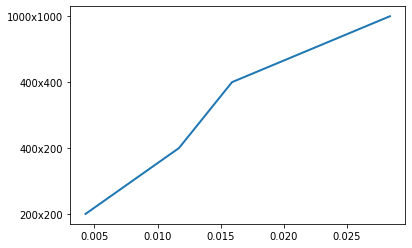

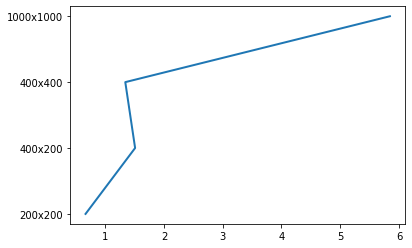

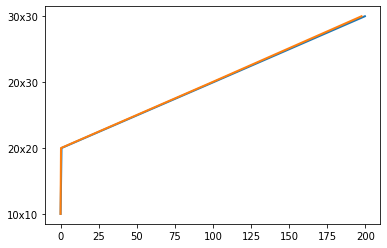

In [201]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(times_heuristic, length_heuristic, linewidth=2.0)
plt.show()
fig, ax = plt.subplots()
ax.plot(times_local_search, length_local_search, linewidth=2.0)
plt.show()
fig, ax = plt.subplots()
ax.plot(times_exhaustive_search_first_program, length_exhaustive_search, linewidth=2.0)
ax.plot(times_exhaustive_search_second_program, length_exhaustive_search, linewidth=2.0)
plt.show()


 Nos gráficos acima podemos notar um aumento gradativo para os dois primeiros algoritmos que são a heurística e a busca local enquanto que na busca exaustiva tem um aumento repentino de mais de 100 vezes entre a entrada de 20x20 (tamanho das sequências) com a de 20x30. É possível notar também que a busca exaustiva leva um tempo bem maior do que os outros dois algoritmos para entradas menores.

### Análise com várias entradas para heurística

In [202]:
import random
import subprocess
import time

times_heuristic = []
length_heuristic = []
heuristic = []

for i in range(0, 10):
    n = random.randrange(1000) # tamanho da primeira sequência
    m = random.randrange(1000) # tamanho da segunda sequência
    file = 'dna.seq' # nome do arquivo a ser gerado
    f = open(file, 'w')
    seq=[str(n)+'\n',
        str(m)+'\n',
        ''.join(random.choices(['A','T','C','G','-'],k=n))+'\n',
        ''.join(random.choices(['A','T','C','G','-'],k=m))]
    f.writelines(seq)
    f.close()
    
    initial_time = time.time()

    subprocess.run("./heuristica < dna.seq", shell=True)

    final_time = time.time()

    difference_between_times = final_time - initial_time

    heuristic.append({"Time": str("%.4f" % difference_between_times), "Length": str(n) + "x" + str(m), "Value": n + m})


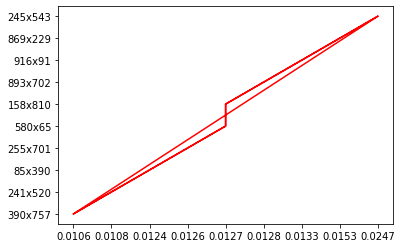

In [224]:
def bigger_value(element):
    return element['Time']

heuristic.sort(key=bigger_value)


for i in heuristic:
    times_heuristic.append(i['Time'])
    length_heuristic.append(i['Length'])

fig, ax = plt.subplots()
ax.plot(times_heuristic, length_heuristic, 'r')
plt.show()

É possível observar no gráfico acima que para entradas maiores o programa demora mais para executar mas mesmo assim consegue rodar em tempos pequenos.

### Análise com várias entradas para busca local

In [205]:
times_local_search = []
length_local_search = []
local_search = []

for i in range(0, 10):
    n = random.randrange(1000) # tamanho da primeira sequência
    m = random.randrange(1000) # tamanho da segunda sequência
    file = 'dna.seq' # nome do arquivo a ser gerado
    f = open(file, 'w')
    seq=[str(n)+'\n',
        str(m)+'\n',
        ''.join(random.choices(['A','T','C','G','-'],k=n))+'\n',
        ''.join(random.choices(['A','T','C','G','-'],k=m))]
    f.writelines(seq)
    f.close()

    initial_time = time.time()

    subprocess.run("./busca_local < dna.seq", shell=True)

    final_time = time.time()

    difference_between_times = final_time - initial_time

    local_search.append({"Time": float("%.3f" % difference_between_times), "Length": str(n) + "x" + str(m), "Value": n + m})


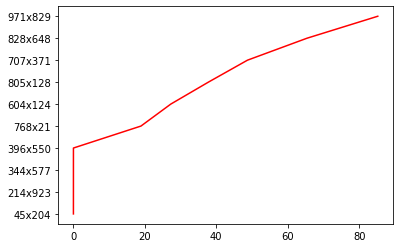

In [208]:
local_search.sort(key=bigger_value)
times_local_search = []
length_local_search = []

for i in local_search:
    times_local_search.append(i['Time'])
    length_local_search.append(i['Length'])
    
fig, ax = plt.subplots()
ax.plot(times_local_search, length_local_search, 'r')
plt.show()

É possível observar que a estratégia de busca local segue a mesma tendência da heurística quanto maior a entrada maior o tempo de execução.

### Análise com várias entradas para busca exaustiva

In [212]:
times_exhaustive_search_first_program = []
length_exhaustive_search = []
exaustive_search = []

for i in range(0, 10):
    n = random.randrange(20) # tamanho da primeira sequência
    m = random.randrange(20) # tamanho da segunda sequência
    file = 'dna.seq' # nome do arquivo a ser gerado
    f = open(file, 'w')
    seq=[str(n)+'\n',
        str(m)+'\n',
        ''.join(random.choices(['A','T','C','G','-'],k=n))+'\n',
        ''.join(random.choices(['A','T','C','G','-'],k=m))]
    f.writelines(seq)
    f.close()
    
    initial_time = time.time()

    subprocess.run("./busca_exaustiva < dna.seq", shell=True)

    final_time = time.time()

    difference_between_times = final_time - initial_time

    exaustive_search.append({"Time": float("%.3f" % difference_between_times), "Length": str(n) + "x" + str(m), "Value": n + m})

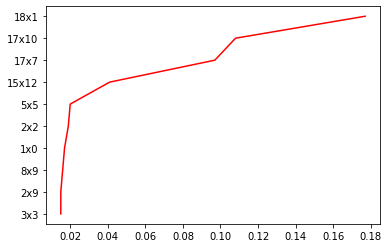

In [213]:
exaustive_search.sort(key=bigger_value)


times_exhaustive_search_first_program = []
length_exhaustive_search = []

for i in exaustive_search:
    times_exhaustive_search_first_program.append(i['Time'])
    length_exhaustive_search.append(i['Length'])
    
fig, ax = plt.subplots()
ax.plot(times_exhaustive_search_first_program, length_exhaustive_search, 'r')
plt.show()

A busca exaustiva tem o mesmo comportamento dos outros dois códigos.

Paralelismo com o OpenMP - Supercomputação

O código escolhido foi o da busca exaustiva. Para isso utilizou-se de tasks na criação das subsequências e no cálculo das pontuações. No primeiro código utilizou-se dois vetores de tamanhos n e m que cada um disparava uma task com uma função recursiva para geração das subsequências.
Foi observado um bom speedup entre a versão serial da busca exaustiva e a primeira versão paralela. Para entrada in3_busca_exaustiva.txt, a versão serial encontrou o resultado em 157.73 segundos a versão paralelizada encontrou o mesmo resultado em 96.23 segundos, e o resultado foi o seguinte: quatorze de pontuação e as seguintes subsequências.
	
TTACCGGCTACCCAAAC-CTAG-GGT-GAA
TCCCCGGCTA


Foi utilizado a busca exaustiva pelos tempos maiores e pela observação no relatório preliminar do projeto de uma quantidade muito grande de iterações nessa parte de geração das subsequências no profilling.
No segundo código a diferença é que paralelizamos a geração das pontuações criando uma task para cada par de subsequência a ser calculado a pontuação. Para a mesma entrada in3_busca_exaustiva.txt, a versão serial que apresentava um tempo de 157.73 segundos quando comparada a versão dois paralela há um speedup ainda maior, passando o tempo para 77.79 segundos com a mesma resposta da versão serial e da paralela versão um.

In [214]:
%%writefile busca_exaustiva_paralela.cpp
#include <iostream>
#include <vector>
#include <algorithm>
#include <omp.h>

using namespace std;

void create_subsequences(vector<char>& dnas, vector<vector<char> >& subsequences, vector<char>& subsequence, int index, int n){
    if (index == n){
        // Compares if subsequence string is in dnas string. If its in add it to the matrix.
        string subsequence_string(subsequence.begin(), subsequence.end());
        string dnas_string(dnas.begin(), dnas.end());
        if (dnas_string.find(subsequence_string) != string::npos) {
            subsequences.push_back(subsequence);
        }
    } else {
        subsequence.push_back(dnas[index]);
        create_subsequences(dnas, subsequences, subsequence, index + 1, n);
        subsequence.pop_back();
        create_subsequences(dnas, subsequences, subsequence, index + 1, n);

    }
}



int main() {

    // Defining n and m. Value of n is the length of the first sequence. Value of m is the length of the second sequence.
    int n; int m;

    // Reads n and m. 
    cin >> n >> m;

    // Defining the two vectors that receive the sequences.
    vector<char> dnas_first_seq;
    vector<char> dnas_second_seq;

    // Reserving n and m length on the vectors.
    dnas_first_seq.reserve(n);
    dnas_second_seq.reserve(m);

    char dna_next;

    // Reads the first sequence and completes the dna_first_seq vector with the sequence.
    for(int i = 0; i < n; i++) {
        cin >> dna_next;
        dnas_first_seq.push_back(dna_next);
    }

    // Reads the second sequence and completes the dna_second_seq vector with the sequence.
    for(int i = 0; i < m; i++) {
        cin >> dna_next;
        dnas_second_seq.push_back(dna_next);
    }
    
    // Creating matrixes that will contain the subsequences of a and b.
    vector<vector<char> > subsequences_a;
    vector<vector<char> > subsequences_b;

    vector<char> subsequence_a;
    vector<char> subsequence_b;

    // Creating subsequences recursively.
    #pragma omp parallel
    {
        // Creating tasks for each sequence to create subsequences.
        #pragma omp master
        {
            #pragma omp task
            {
                create_subsequences(dnas_first_seq, subsequences_a, subsequence_a, 0, n);
            }
            #pragma omp task
            {
                create_subsequences(dnas_second_seq, subsequences_b, subsequence_b, 0, m);
            }
        }
    }
    
    // Erase duplicates.
    subsequences_a.erase(unique(subsequences_a.begin(), subsequences_a.end()), subsequences_a.end());
    subsequences_b.erase(unique(subsequences_b.begin(), subsequences_b.end()), subsequences_b.end());

    // Create matrix that will contain the scores.
    vector<vector<int> > scores;

    vector<int> scores_next;

    for (int i = 0; i < subsequences_a.size(); i++) {
        scores.push_back(scores_next);
    }

    int sum_score_pair = 0;

    // Calculate scores. If subsequence of a bigger than subsequence of b calculate
    // for all elements of b and the first elements of a that has the same size of 
    // b subsequence. Else the inverse.
    for (int i = 0; i < subsequences_a.size(); i++) {
        for (int j = 0; j < subsequences_b.size(); j++) {
            if (subsequences_a[i].size() > subsequences_b[j].size()) {
                for (int k = 0; k < subsequences_b[j].size(); k++) {
                    if (subsequences_a[i][k] == subsequences_b[j][k]) {
                        sum_score_pair+=2;
                    } else {
                        sum_score_pair-=1;
                    }
                }
            } else {
                for (int k = 0; k < subsequences_a[i].size(); k++) {
                    if (subsequences_a[i][k] == subsequences_b[j][k]) {
                        sum_score_pair+=2;
                    } else {
                        sum_score_pair-=1;
                    }
                }
            }
            scores[i].push_back(sum_score_pair);
            sum_score_pair = 0;
        }
    }

    int max_score = 0;

    int max_x = 0;
    int max_y = 0;

    // Get the max score and the subsequences correlated to the max score.
    for (int i = 0; i < scores.size(); i++) {
        for (int j = 0; j < scores[0].size(); j++) {
            if (scores[i][j] > max_score) {
                max_x = i;
                max_y = j;
                max_score = scores[i][j];
            }
        }
    }

    cout << max_score;
    cout << endl;

    for(auto& subsequence_a: subsequences_a[max_x]) {
        cout << subsequence_a;
    }

    cout << endl;

    for(auto& subsequence_b: subsequences_b[max_y]) {
        cout << subsequence_b;
    }


}

Overwriting busca_exaustiva_paralela.cpp


In [215]:
!g++ -g busca_exaustiva_paralela.cpp -o busca_exaustiva_paralela

In [216]:
import random
import time
import subprocess
times_exhaustive_search_first_program_omp = []
length_exhaustive_search_omp = []
exaustive_search_omp = []

for i in range(0, 10):
    n = random.randrange(10) # tamanho da primeira sequência
    m = random.randrange(10) # tamanho da segunda sequência
    file = 'dna.seq' # nome do arquivo a ser gerado
    f = open(file, 'w')
    seq=[str(n)+'\n',
        str(m)+'\n',
        ''.join(random.choices(['A','T','C','G','-'],k=n))+'\n',
        ''.join(random.choices(['A','T','C','G','-'],k=m))]
    f.writelines(seq)
    f.close()
    
    initial_time = time.time()

    subprocess.run("./busca_exaustiva_paralela < dna.seq", shell=True)

    final_time = time.time()

    difference_between_times = final_time - initial_time

    exaustive_search_omp.append({"Time": float("%.3f" % difference_between_times), "Length": str(n) + "x" + str(m), "Value": n + m})

    


[{'Time': 0.012, 'Length': '1x0', 'Value': 1}, {'Time': 0.012, 'Length': '0x3', 'Value': 3}, {'Time': 0.013, 'Length': '6x8', 'Value': 14}, {'Time': 0.013, 'Length': '0x0', 'Value': 0}, {'Time': 0.014, 'Length': '5x6', 'Value': 11}, {'Time': 0.015, 'Length': '0x7', 'Value': 7}, {'Time': 0.016, 'Length': '8x2', 'Value': 10}, {'Time': 0.016, 'Length': '6x6', 'Value': 12}, {'Time': 0.017, 'Length': '6x8', 'Value': 14}, {'Time': 0.021, 'Length': '7x5', 'Value': 12}]


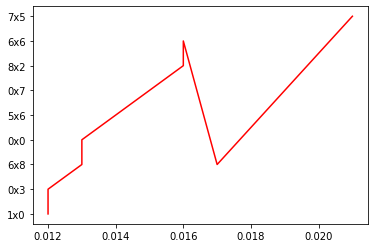

In [220]:
import matplotlib.pyplot as plt

length_exhaustive_search_omp = []
times_exhaustive_search_first_program_omp = []

def bigger_value(element):
    return element['Time']

newlist = (sorted(exaustive_search_omp, key = lambda i: i['Time']))

print(newlist)

for i in newlist:
    times_exhaustive_search_first_program_omp.append(i['Time'])
    length_exhaustive_search_omp.append(i['Length'])
    
fig, ax = plt.subplots()
ax.plot(times_exhaustive_search_first_program_omp,length_exhaustive_search_omp, 'r')

plt.show()

É possível verificar no gráfico acima que quanto maior a entrada dos dados maior é o tempo para execução.

Paralelismo GPU

In [221]:
%%writefile paralelismoGPU.cu
#include <thrust/transform.h>
#include <thrust/device_vector.h>
#include <thrust/host_vector.h>
#include <thrust/iterator/counting_iterator.h>
#include <iostream>
#include <thrust/copy.h>
#include <omp.h>


using namespace std;
using namespace thrust;

struct calculate_score
{
    char letter;
    thrust::device_ptr<char> data_subsequence;
    thrust::device_ptr<int> last_line_calculation;

    calculate_score(thrust::device_ptr<char> _data_subsequence, char _letter, thrust::device_ptr<int>_last_line_calculation) : data_subsequence(_data_subsequence), letter(_letter), last_line_calculation(_last_line_calculation) {};

    __host__ __device__
    int operator()(const int& i) {

        int diagonal = 0;
        int insertion = last_line_calculation[i] - 1;

        if (data_subsequence[i-1] == letter) {
            diagonal = last_line_calculation[i-1] + 2;
        } else {
            diagonal = last_line_calculation[i-1] - 1;
        }

        if (diagonal > insertion) {
            if (diagonal > 0) {
                return diagonal;
            } else {
                return 0;
            }
        } else {
            if (insertion > 0) {
                return insertion;
            } else {
                return 0;
            }
        }
    }
};

int main() {

    double n = 0;
    double m = 0;

    cin >> n >> m;

    host_vector<char> dnas_first_seq_cpu;
    host_vector<char> dnas_second_seq_cpu;

    dnas_first_seq_cpu.reserve(n);
    dnas_second_seq_cpu.reserve(m);

    char dna_next;

    // Reads the first sequence and completes the dna_first_seq vector with the sequence.
    for(int i = 0; i < n; i++) {
        cin >> dna_next;
        dnas_first_seq_cpu.push_back(dna_next);
    }

    // Reads the second sequence and completes the dna_second_seq vector with the sequence.
    for(int i = 0; i < m; i++) {
        cin >> dna_next;
        dnas_second_seq_cpu.push_back(dna_next);
    }
    
    int k = n;
    int l = m;

    host_vector<char> dnas_first_seq_cpu_flexible = dnas_first_seq_cpu;
    host_vector<char> dnas_second_seq_cpu_flexible = dnas_second_seq_cpu;

    host_vector<host_vector<char> > subsequences_a;
    host_vector<host_vector<char> > subsequences_b;

    while (dnas_first_seq_cpu_flexible.size() > 0) {
        while(k > 0) {
            host_vector<char> next_subsequence;
            for (int j = 0; j < k; j++) {
                next_subsequence.push_back(dnas_first_seq_cpu_flexible[j]);
            }
            k = k - 1;

            subsequences_a.push_back(next_subsequence);
            next_subsequence.clear();
        }
        dnas_first_seq_cpu_flexible.erase(dnas_first_seq_cpu_flexible.begin());
        k = dnas_first_seq_cpu_flexible.size();
    }

    while (dnas_second_seq_cpu_flexible.size() > 0) {
        while(l > 0) {
            host_vector<char> next_subsequence;
            for (int j = 0; j < l; j++) {
                next_subsequence.push_back(dnas_second_seq_cpu_flexible[j]);
            }
            l = l - 1;

            subsequences_b.push_back(next_subsequence);
            next_subsequence.clear();
        }
        dnas_second_seq_cpu_flexible.erase(dnas_second_seq_cpu_flexible.begin());
        l = dnas_second_seq_cpu_flexible.size();
    }

    int max_score = 0;


    for (int i = 0; i < subsequences_a.size(); i++) {
        char *subsequence_from_sequence_a = subsequences_a[i].data();
        device_vector<char> subsequence_a_gpu = subsequences_a[i];

        for (int j = 0; j < subsequences_b.size(); j++) {
            char *subsequence_from_sequence_b = subsequences_a[j].data();
            device_vector<char> subsequence_b_gpu = subsequences_b[j];
            device_vector<int> calculation_temp(subsequences_a[i].size() + 1);
            device_vector<int> calculation_score(subsequences_a[i].size() + 1);

            thrust::fill(calculation_temp.begin(), calculation_temp.end(), 0);

            #pragma omp parallel
            {
                // Creating tasks for each sequence to create subsequences.
                #pragma omp master
                {
                    for (int t = 0; t < subsequences_b[j].size(); t++) {
                    #pragma omp task
                    {

                            char letter_from_subsequence_b = subsequences_b[j][t];

                            thrust::device_vector<int> counting(subsequence_a_gpu.size() + 1);

                            for (int q = 0; q < subsequences_a[i].size() + 1; q++) {
                                counting[q] = q;
                            }

                            thrust::transform(counting.begin(), counting.end(), calculation_score.begin(), calculate_score(subsequence_a_gpu.data(), letter_from_subsequence_b, calculation_temp.data()));
                            thrust::inclusive_scan(calculation_score.begin()+1, calculation_score.end(), calculation_temp.begin() + 1, thrust::maximum<int>());

                            int max = *max_element(calculation_temp.begin(), calculation_temp.end());

                            cout << max;
                            cout << endl;
                            cout << max_score;

                            if (max > max_score) {
                                max_score = max;
                                cout << max_score;

                            }
                        }                    
                    }
                }
            }
        }
    }

    cout << max_score;
}

Overwriting paralelismoGPU.cu


In [222]:
!nvcc -arch=sm_70 -std=c++14 paralelismoGPU.cu -o busca_exaustiva_paralela_gpu -Xcompiler -fopenmp

In [223]:
import random
import time
import subprocess
times_exhaustive_search_first_program_gpu = []
length_exhaustive_search_gpu = []
exaustive_search_gpu = []

for i in range(0, 10):
    n = random.randrange(1000) # tamanho da primeira sequência
    m = random.randrange(1000) # tamanho da segunda sequência
    file = 'dna.seq' # nome do arquivo a ser gerado
    f = open(file, 'w')
    seq=[str(n)+'\n',
        str(m)+'\n',
        ''.join(random.choices(['A','T','C','G','-'],k=n))+'\n',
        ''.join(random.choices(['A','T','C','G','-'],k=m))]
    f.writelines(seq)
    f.close()
    
    initial_time = time.time()

    subprocess.run("./busca_exaustiva_paralela_gpu < dna.seq", shell=True)

    final_time = time.time()

    difference_between_times = final_time - initial_time

    exaustive_search_gpu.append({"Time": float("%.2f" % difference_between_times), "Length": str(n) + "x" + str(m), "Value": n + m})

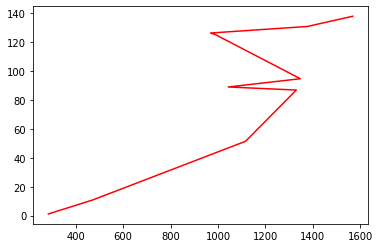

In [225]:
import matplotlib.pyplot as plt

times_exhaustive_search_first_program_gpu = []
length_exhaustive_search_gpu = []

newlist = sorted(exaustive_search_gpu, key=lambda d: d['Time']) 

for i in newlist:
    times_exhaustive_search_first_program_gpu.append(i['Time'])
    length_exhaustive_search_gpu.append(i['Value'])

fig, ax = plt.subplots()
ax.plot(length_exhaustive_search_gpu, times_exhaustive_search_first_program_gpu, 'r')

plt.show()

Como é possível verificar no gráfico acima o tempo de execução da busca exaustiva paralela com o Thrust e o openMP ficou muito mais rápido e roda entradas com até 1600 elementos de entrada em até 140 segundos sendo que a busca exaustiva levava 200 segundos para rodar entradas com até 60 elementos e esse número sobe muito para entradas com 80 elementos.

### Comparando todos os códigos com as mesmas entradas

In [226]:
import random
import time
import subprocess

times_heuristic = []
length_heuristic = []
heuristic = []

times_local_search = []
length_local_search = []
local_search = []

times_exhaustive_search = []
length_exhaustive_search = []
exaustive_search = []

times_exhaustive_search_omp = []
length_exhaustive_search_omp = []
exaustive_search_omp = []

times_exhaustive_search_gpu = []
length_exhaustive_search_gpu = []
exaustive_search_gpu = []

for i in range(0, 10):
    n = random.randrange(20) # tamanho da primeira sequência
    m = random.randrange(20) # tamanho da segunda sequência
    file = 'dna.seq' # nome do arquivo a ser gerado
    f = open(file, 'w')
    seq=[str(n)+'\n',
        str(m)+'\n',
        ''.join(random.choices(['A','T','C','G','-'],k=n))+'\n',
        ''.join(random.choices(['A','T','C','G','-'],k=m))]
    f.writelines(seq)
    f.close()
    
    initial_time = time.time()

    subprocess.run("./heuristic < dna.seq", shell=True)

    final_time = time.time()

    difference_between_times = final_time - initial_time

    heuristic.append({"Time": float("%.3f" % difference_between_times), "Length": str(n) + "x" + str(m), "Value": n + m})

    initial_time = time.time()

    subprocess.run("./busca_local < dna.seq", shell=True)

    final_time = time.time()

    difference_between_times = final_time - initial_time

    local_search.append({"Time": float("%.3f" % difference_between_times), "Length": str(n) + "x" + str(m), "Value": n + m})

    initial_time = time.time()

    subprocess.run("./busca_exaustiva < dna.seq", shell=True)

    final_time = time.time()

    difference_between_times = final_time - initial_time

    exaustive_search.append({"Time": float("%.3f" % difference_between_times), "Length": str(n) + "x" + str(m), "Value": n + m})

    initial_time = time.time()

    subprocess.run("./busca_exaustiva_paralela < dna.seq", shell=True)

    final_time = time.time()

    difference_between_times = final_time - initial_time

    exaustive_search_omp.append({"Time": float("%.3f" % difference_between_times), "Length": str(n) + "x" + str(m), "Value": n + m})

    initial_time = time.time()

    subprocess.run("./busca_exaustiva_paralela_gpu < dna.seq", shell=True)

    final_time = time.time()

    difference_between_times = final_time - initial_time

    exaustive_search_gpu.append({"Time": float("%.3f" % difference_between_times), "Length": str(n) + "x" + str(m), "Value": n + m})

    

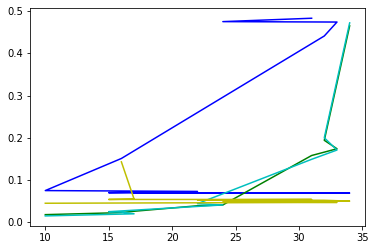

In [231]:
import matplotlib.pyplot as plt

times_local_search = []
length_local_search = []

times_exhaustive_search = []
length_exhaustive_search = []

times_exhaustive_search_omp = []
length_exhaustive_search_omp = []

times_exhaustive_search_gpu = []
length_exhaustive_search_gpu = []

local_search = (sorted(local_search, key = lambda i: i['Time']))
exaustive_search = (sorted(exaustive_search, key = lambda i: i['Time']))
exaustive_search_omp = (sorted(exaustive_search_omp, key = lambda i: i['Time']))
exaustive_search_gpu = (sorted(exaustive_search_gpu, key = lambda i: i['Time']))


for i in local_search:
    times_local_search.append(i['Time'])
    length_local_search.append(i['Value'])

for i in exaustive_search:
    times_exhaustive_search.append(i['Time'])
    length_exhaustive_search.append(i['Value'])

for i in exaustive_search_omp:
    times_exhaustive_search_omp.append(i['Time'])
    length_exhaustive_search_omp.append(i['Value'])

for i in exaustive_search_gpu:
    times_exhaustive_search_gpu.append(i['Time'])
    length_exhaustive_search_gpu.append(i['Value'])

fig, ax = plt.subplots()
ax.plot(length_local_search, times_local_search, 'b')
ax.plot(length_exhaustive_search, times_exhaustive_search, 'g')
ax.plot(length_exhaustive_search_omp, times_exhaustive_search_omp, 'c')
ax.plot(length_exhaustive_search_gpu, times_exhaustive_search_gpu, 'y')
plt.show()

Nesse gráfico podemos observar que a linha amarela correspondente á busca exaustiva em GPU com Thrust e OpenMP é que tem maior performance. A linha correspondente a busca exaustiva tanto paralela (com somente o OpenMP) e a serial são muito parecidas. E a de busca local não tem um padrão para um número pequeno de entradas.

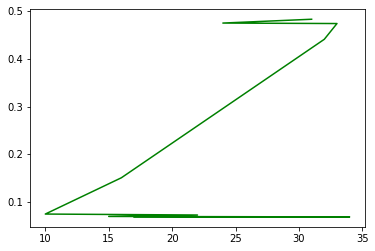

In [233]:
fig, ax = plt.subplots()
ax.plot(length_local_search, times_local_search, 'g')
plt.show()

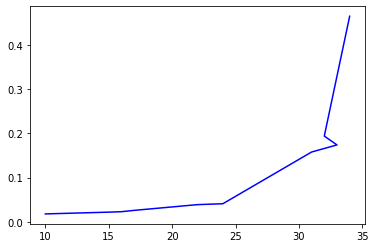

In [234]:
fig, ax = plt.subplots()
ax.plot(length_exhaustive_search, times_exhaustive_search, 'b') 
plt.show()

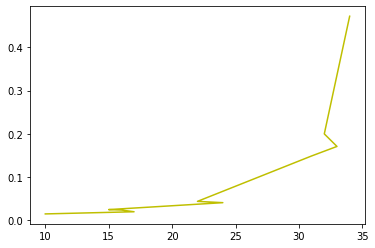

In [235]:
fig, ax = plt.subplots()
ax.plot(length_exhaustive_search_omp, times_exhaustive_search_omp, 'y')
plt.show()

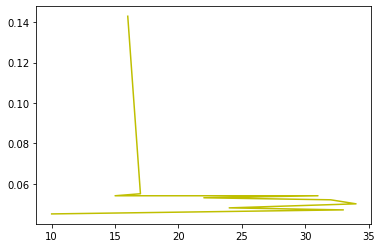

In [236]:
fig, ax = plt.subplots()
ax.plot(length_exhaustive_search_gpu, times_exhaustive_search_gpu, 'y')
plt.show()

### Conclusão

A medida que as entradas vão aumentando o tempo de execução também aumenta. O que acontece com a busca exaustiva é mais gritante pois de entradas 20x20 para entradas 30x30 o código executa com uma diferença de quase 200 segundos. Quando implentamos o openMP para a busca exaustiva esse número diminiu um pouco. E quando implementamos openMP mais o Thrust esse número diminui muito e conseguimos rodar entradas de até 2000 elementos.